# PRÁCTICA API


Imports de las librerías a utilizar

In [41]:
import requests
import pandas as pd
from fpdf import FPDF
import dataframe_image as dfi
import matplotlib.pyplot as plt
import seaborn as sns
import re


PDF Class

In [42]:
class PDF(FPDF):
    
    def portada(self,image):

        self.set_y(40)
        self.set_font('Arial','B',30)
        self.cell(0,20,'Informe estadístico NBA',ln=True, align='C')
        self.ln(3)
        self.cell(0,20,'BOSTON CELTICS',ln=True, align='C')
        self.insert_image(image,[150,150],[30,100])
        
    def footer(self):
                
        self.set_y(-20)
        self.set_font('Arial','',8)
        self.cell(0,10,f'Página {self.page_no()}',align = 'C')

    def escribir_tit_doc(self,titulo, image = None):
    
        self.set_font('Arial', 'B', 20)
        if image:
            self.insert_image(image,[25,25],[170,4])
    
        self.cell(0, 6, f'{titulo}' , 0 , 1, 'L', 0)
        self.ln(1)  
        
    def escribir_tit_seccion(self,titulo):
    
        self.set_font('Arial', 'B', 12)
        
        self.cell(0, 6, f'{titulo}' , 'B', 1, 'L', 0)
        self.ln(2)
        
    def insert_espacio(self,lon):
    
        self.ln(lon)
        
    def insert_image(self,im_name, tamaño, pos = None):
    
        if pos:
            self.image(im_name,x = pos[0],y = pos[1], w = tamaño[0], h = tamaño[1])
        else:
            self.image(im_name, w = tamaño[0], h = tamaño[1])
        self.ln(5)
    
    def escribir_par(self,texto):
        
        self.ln(3)
        self.set_font('Arial', '', 11)
        self.multi_cell(0, 5, texto)

        

ETL

In [43]:
# REQUEST
# Vamos a extraer información sobre el equipo Boston Celtics

def extract(url):

  # Extraemos las credenciales
  
  file = open('config.txt', 'r')
  texto = file.read()
  file.close()
  
  credenciales = re.findall('\d+$',texto)
    
  
  payload={}
  headers = {
    'x-rapidapi-key': credenciales,
    'x-rapidapi-host': 'https://v2.nba.api-sports.io/'
  }

  response = requests.request("GET", url, headers=headers, data=payload)
  
  return response


In [44]:
def transform(response):
    
    data = (response.json())['response']
    df = pd.DataFrame(data)
    
    return df


In [45]:
def load(df_ini):
    
    # Cambiamos los nombres de la tabla para trabajar mejor con ello

    df_ini = df_ini.rename(columns={
                'offReb':'Offensive Rebounds',
                'defReb': 'Defensive Rebounds',
                'totReb': 'Total Rebounds',
                'fastBreakPoints':'Fast Break Points',
                'games':'Games',
                'biggestLead':'Biggest Lead',
                'secondChancePoints':'Second Chance Points',
                'pointsOffTurnovers':'Points Off Turnovers',
                'longestRun':'Longest Run',
                'points':'Points',
                'fgm':'Field Goals Made',
                'fga':'Field Goals Attempted',
                'fgp':'Field Goals Percentage',
                'ftm':'Free Throws Made',
                'fta':'Free Throws Attempted',
                'ftp':'Free Throws Percentage',
                'tpm':'TPM',
                'tpa':'TPA',
                'tpp':'TPP',
                'assists':'Assists',
                'pFouls':'Fouls',
                'steals':'Steals',
                'turnovers':'Turnovers',
                'blocks':'Blocks',
                'plusMinus':'Plus/Minus'
                })
    
    # Creamos las imágenes a meter en el pdf
    
    # Piechart de bloqueos, regates y robar el balón
    
    fig = plt.figure(figsize=(8,8))
    robos = df_ini.loc[0,'Steals']
    regates = df_ini.loc[0,'Turnovers']
    bloqueos = df_ini.loc[0,'Blocks']
    data = [robos,regates,bloqueos]

    lbls = ['Robos','Regates','Bloqueos']
    plt.pie(data,
            labels=lbls,
            colors = ['lightgreen','lightblue','blue'])

    plt.title('Comparación robo-bloqueo-regate')

    plt.savefig('piechart.jpg')
    
    # Gráfico de barras comparativo entre rebotes defensivos y ofensivos
    
    fig = plt.figure(figsize=(8,8))
    plt.title('Comparativa de tipo de rebote', fontsize = 20,fontweight='bold')
    
    
    data2 = df_ini[['Offensive Rebounds','Defensive Rebounds']]
    sns.set_style('darkgrid')
    ax = sns.barplot(data2 , # Dataframe
                # orient = 'v',
                palette = 'viridis')
    plt.savefig('barplot.png')
    
    # Gráfico de barras comparativo entre puntos intentados y marcados
    
    fig = plt.figure(figsize=(10,8))
    plt.title('Comparativa de tiros', fontsize = 20,fontweight='bold')
    
    
    data3 = df_ini[['Field Goals Made','Field Goals Attempted']]
    sns.set_style('darkgrid')
    ax = sns.barplot(data3 , # Dataframe
                orient = 'h',
                palette = 'viridis')
    plt.savefig('barplot2.png')
    
     # Tabla
    
    df = df_ini.transpose()
    df_fn = df.rename(columns={0:'Boston Celtics values'})
    dfi.export(df_fn,'tabla1.png',table_conversion='matplotlib')
    
    
    # Creamos el PDF
    
    pdf = PDF('P','mm','A4')

    pdf.set_auto_page_break(auto=True,margin=100)

    # Creamos portada

    pdf.add_page()
    pdf.portada('BC_logo.png')
    pdf.add_page()

    # Página 1

    texto = 'A continuación mostraremos gráficamente las distintas estadísticas relativas a los Boston Celtics.\nEstas han sido elaboradas utilizando la información obtenida de fuentes como API.sports.io y páginas oficiales de predicción como sportytrader.com. Todos los datos serán relativos a la última temporada, la actual 22-23.'
    pdf.escribir_tit_doc('Estadísticas principales - Boston Celtics','BC_logo.png')
    pdf.insert_espacio(10)

    pdf.escribir_tit_seccion('Introducción')
    pdf.escribir_par(texto)

    pdf.set_y(pdf.get_y()+10)

    pdf.escribir_tit_seccion('Tabla de estadísticas principales')
    texto2 = 'Incluimos a continuación la tabla que recogerá las principales medidas de estadística avanzada sobre la temporada de los Boston Celtics.'
    pdf.escribir_par(texto2)
    pdf.insert_image('tabla1.png',[95,150],[52.5,pdf.get_y()+1])

    # Página 2

    pdf.add_page()
    pdf.escribir_tit_doc('Estadísticas principales - Boston Celtics','BC_logo.png')
    pdf.insert_espacio(10)

    pdf.escribir_tit_seccion('Comparativa de puntos intentados frente a marcados')
    texto3 = 'Consideramos que la diferencia entre intentos y aciertos en cuanto a los tantos marcados por el equipo puede ser una comparativa reveladora de cara a un posible cambio en la estrategia de entrenamiento. Por ello, resumimos dicha estadística en la siguiente gráfica.'
    pdf.escribir_par(texto3)
    pdf.insert_image('barplot2.png',[100,100],[52.5,pdf.get_y()+1])
    pdf.insert_espacio(105)

    pdf.escribir_tit_seccion('Índice de bloqueos, regates y robos del balón')
    texto4 = 'De cara a un análisis más profundo del juego real del equipo en partido, hemos decidido comparar la cantidad de bloqueos, regates y robos de balón. El objetivo, facilitar un posible redireccionamiento del entrenamiento con la intención de reforzar los puntos débiles del equipo'
    pdf.escribir_par(texto4)
    pdf.insert_image('piechart.jpg',[100,100],[52.5,pdf.get_y()+1])

    # Página 3

    pdf.add_page()
    pdf.escribir_tit_doc('Estadísticas principales - Boston Celtics','BC_logo.png')
    pdf.insert_espacio(10)

    pdf.escribir_tit_seccion('Comparación entre rebotes defensivos y ofensivos')
    texto5 = 'Utilizamos las medidas de tipo de rebote para poder comparar facilmente el número de veces que ocurre una situación ofensiva o defensiva, viendo así cual de ellas es la más habitual para el equipo '
    pdf.escribir_par(texto5)
    pdf.insert_image('barplot.png',[115,120],[52.5,pdf.get_y()+1])

    # Página 4

    pdf.add_page()
    pdf.escribir_tit_doc('Datos predictivos - Boston Celtics','BC_logo.png')
    pdf.insert_espacio(10)
    pdf.escribir_tit_seccion('Predicción de resultados')
    # Accedemos al csv creado con el webscrapping

    dfp = pd.read_csv('pronostico.csv', sep = ',', encoding='utf-8')
    local = list(dfp['Local'])
    vis = list(dfp['Visitante'])

    part_id = {'Local':[],
            'Visitante':[]}
    filas_id = []
    for index in range(len(local)):
        
        if re.findall('Boston Celtics', local[index] , re.I):
            filas_id.append(index)
            
        elif re.findall('Boston Celtics', vis[index] , re.I):
            filas_id.append(index)
            
        else:
            pass

    # Elaboramos el texto a introducir en el pdf

    lon = len(filas_id)

    if lon == 0:
        texto6 = 'Lamentablemente, no se han encontrado próximos partidos para los Boston Celtics, por lo que no se ha podido elaborar la predicción'
    elif lon >= 1:
        texto6 = 'Los  próximos encuentros en los que podremos encontrar a los Boston Celtics y sus resultados predichos serán los siguientes:'
        df_new = dfp.loc[filas_id,['Local','Visitante','Result. local','Result. visit.']]
        dfi.export(df_new,'next_games.png',table_conversion='matplotlib')
        image = True
        
    pdf.escribir_par(texto6)
    if image:
        pdf.insert_image('next_games.png',[130,15],[30,pdf.get_y()+3])
        
        
    # Creamos el pdf y terminamos

    pdf.output('Informe_BC.pdf','F')

    return


Ejecución

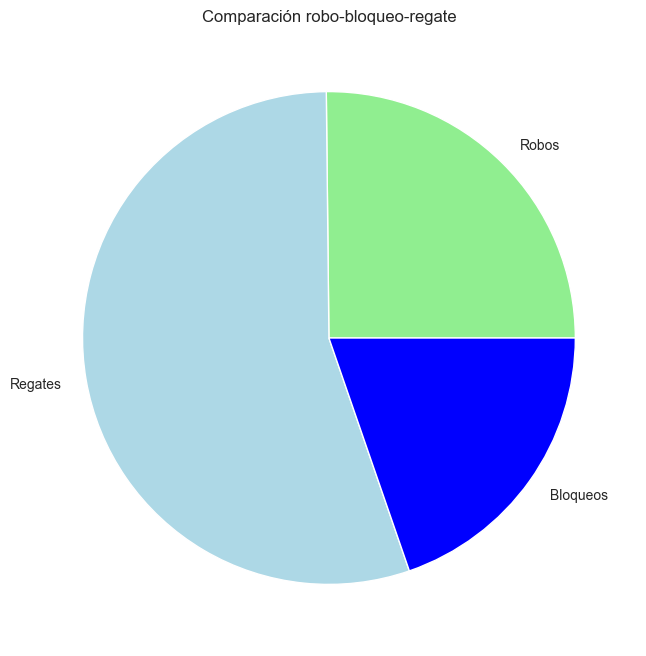

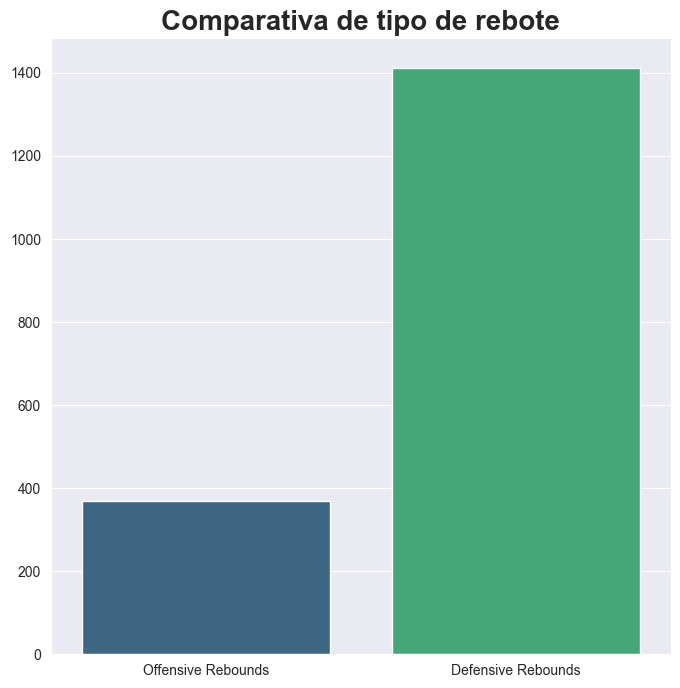

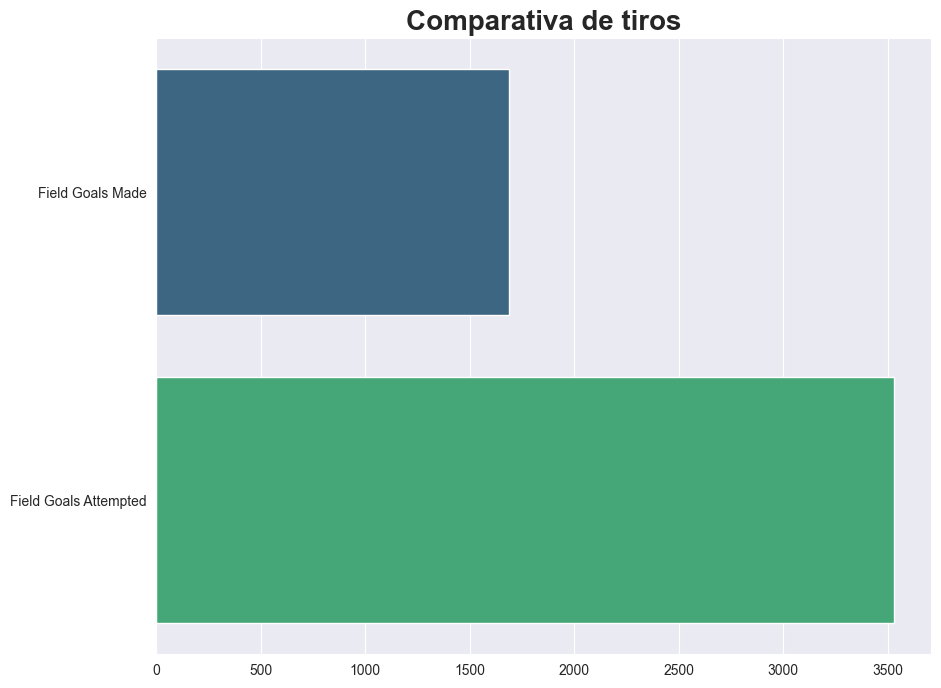

In [46]:
response = extract(url='https://v2.nba.api-sports.io/teams/statistics?season=2022&id=2')
df_stats = transform(response) 
load(df_stats)